# AdventureWorks Försäljningsanalys

I denna analys undersöker vi AdventureWorks-databasen för att besvara affärsfrågor som ex:
- Produktkategorier och deras försäljnig 
- Försäljningstrender
- Regional försäljning

Vi använder SQL för att hämta data och Python för visualisering och analys.

In [1]:
import pandas as pd 
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np 

user = "sa"
password = quote_plus("WorldWide85")
server = 'localhost,1433'
database = 'AdventureWorks2019'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


In [2]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

### Visualisering 1: Antal produkter per kategori
Hur många produkter finns i varje kategori?

Tabeller som använts:
Production.ProductCategory
Production.ProductSubcategory
Production.Product

Planering:
JOINA tabellerna
Räkna DISTINCT produkter per kategori
Skapa vertikalt stapeldiagram
Analsera resultatet

Flest produkter: Components (134)
Minst produkter: Accessories (29)


,CategoryName,ProductCount
0,Components,134
1,Bikes,97
2,Clothing,35
3,Accessories,29


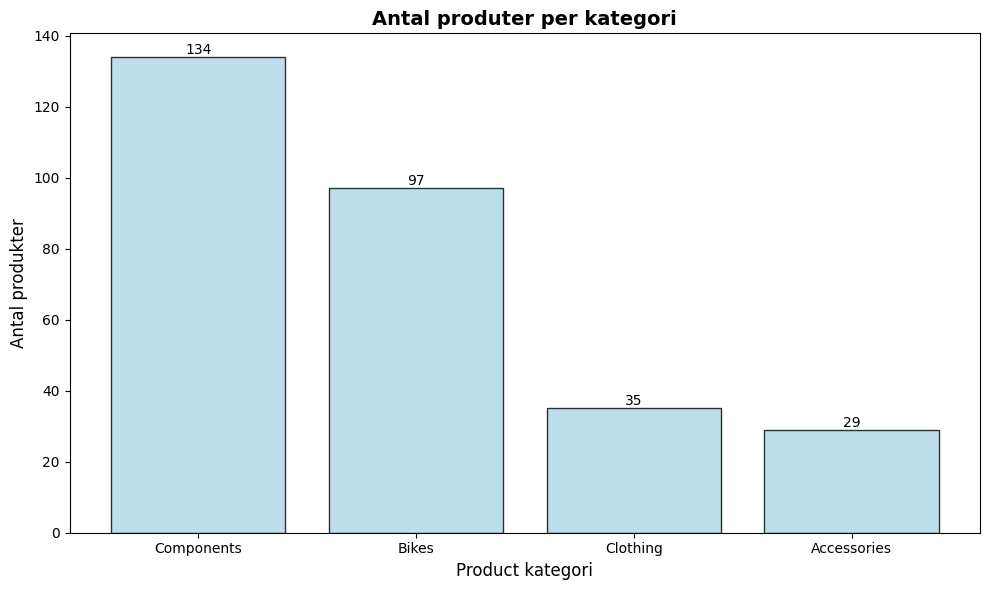

In [3]:
query_vis1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount
  
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC

"""



df_vis1 = query_df(query_vis1)

max_category = df_vis1.iloc[0]['CategoryName']
max_count = int(df_vis1.iloc[0]['ProductCount'])

min_category = df_vis1.iloc[-1]['CategoryName']
min_count = int(df_vis1.iloc[-1]['ProductCount'])

print(f"Flest produkter: {max_category} ({max_count})")
print(f"Minst produkter: {min_category} ({min_count})")
display(df_vis1)

fig, ax = plt.subplots(figsize=(10,6))

bars = ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'], color='lightblue', edgecolor='black', alpha=0.8)

for bar in bars:
    height = bar.get_height()
    ax.text( 
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )
   


ax.set_xlabel('Product kategori',fontsize=12)
ax.set_ylabel('Antal produkter',fontsize=12)
ax.set_title('Antal produter per kategori', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()




### Insikter - Antal produkter per kategori
Components är största kategorin med 134 produkter.
Accessoarer är minst med 29 produkter.

Detta indikerar på att företaget är starkt fokuserat på komponenter och reservdelar.
Och att accessoarer kan vara ett utvecklings område.

### Visualisering 2: Total försäljning per produktkategori

Vilka produktkategorier genererar mest intäkter?

Vi hämtar data från tabellerna SalesOrderDetail, Product, ProductSubcategory och ProductCategory. Vi summerar försäljningen per kategori och sorterar från högst till lägst

Högst försäljning: Bikes (94,651,173)
Lägst försäljning: Accessories (1,272,073)


,CategoryName,TotalSales
0,Bikes,9.465117e+07
1,Components,1.180259e+07
2,Clothing,2.120543e+06
3,Accessories,1.272073e+06


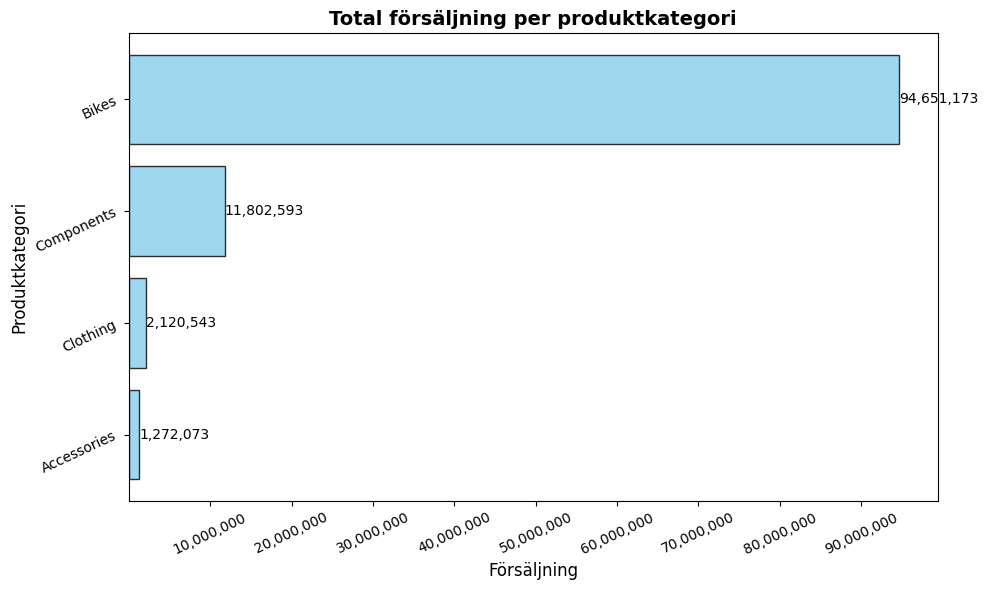

In [4]:
query_vis2 = """ 
SELECT
    pc.Name AS CategoryName,
    SUM(sod.LineTotal) AS TotalSales
FROM 
    Sales.SalesOrderDetail sod
INNER JOIN Production.Product p ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
INNER JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID

GROUP BY 
    pc.Name
ORDER BY
    TotalSales DESC;
"""

df_vis2 = query_df(query_vis2)

max_category = df_vis2.iloc[0]['CategoryName']
max_sales = df_vis2.iloc[0]['TotalSales']

min_category = df_vis2.iloc[-1]['CategoryName']
min_sales = df_vis2.iloc[-1]['TotalSales']

print(f"Högst försäljning: {max_category} ({max_sales:,.0f})")
print(f"Lägst försäljning: {min_category} ({min_sales:,.0f})")
display(df_vis2)


fig, ax = plt.subplots(figsize=(10,6))
bars = ax.barh(df_vis2['CategoryName'], df_vis2['TotalSales'], color='skyblue', edgecolor='black', alpha=0.8)
ax.set_title('Total försäljning per produktkategori',fontsize=14, fontweight='bold')
ax.set_xlabel('Försäljning', fontsize=12)
ax.set_ylabel('Produktkategori', fontsize=12)

ax.invert_yaxis()

xticks = [1e7, 2e7, 3e7, 4e7, 5e7, 6e7, 7e7, 8e7, 9e7]
ax.set_xticks(xticks)

# Visa siffrorna med kommatecken
ax.ticklabel_format(style='plain', axis='x')
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))


for bar in bars:
    width = bar.get_width()
    ax.text(
        width, 
        bar.get_y() + 
        bar.get_height()/2,
        f'{width:,.0f}', 
        va='center'
    )

plt.yticks(rotation=25) 
plt.xticks(rotation=25) 
plt.tight_layout()
plt.show()


### Insikter - Totalförsäljning per produktkategori

Stapeldiagrammet visar tydligt vilken produktkategori som genererar mest och minst försäljning.  

Kategorin **Bikes** har högst total försäljning med 94,651,173 sålda.  
Kategorin **Accessories** har lägst total försäljning med 1,272,072 sålda.  

Detta hjälper oss att förstå vilka produktområden som bidrar mest till intäkterna.


### Visualisering 3: Försäljningstrend per månad

Hur har försäljningen utvecklats över tid? Finns det säsongsvariationer eller en generell trend?

Vi hämtar försäljningsdata från Sales.SalesOrderHeader, aggregerar total försäljning per månad och sorterar kronologiskt. Visualiserar sedan med ett linjediagram för att visa trenden.


,YearMonth,TotalSales
0,2011-05,5.670209e+05
1,2011-06,5.070965e+05
2,2011-07,2.292183e+06
3,2011-08,2.800576e+06
4,2011-09,5.547916e+05
5,2011-10,5.156270e+06
6,2011-11,8.153130e+05
7,2011-12,1.462449e+06
8,2012-01,4.458337e+06
9,2012-02,1.649052e+06


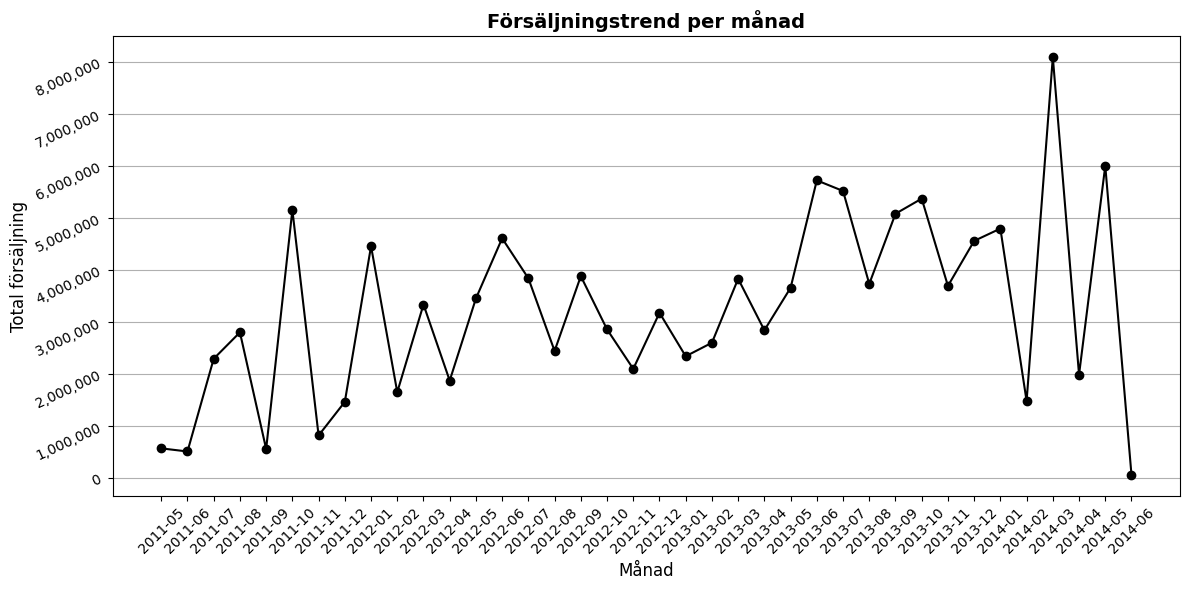

In [5]:
query_vis3 = """
SELECT 
    CAST(YEAR(OrderDate) AS VARCHAR(4)) + '-' + RIGHT('0' + CAST(MONTH(OrderDate) AS VARCHAR(2)), 2) AS YearMonth,
    SUM(TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate), MONTH(OrderDate)
ORDER BY YEAR(OrderDate), MONTH(OrderDate);
"""

df_vis3 = query_df(query_vis3)
display(df_vis3)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df_vis3['YearMonth'], df_vis3['TotalSales'], marker='o', linestyle='-', color='black')

ax.set_title('Försäljningstrend per månad', fontsize=14, fontweight='bold')
ax.set_xlabel('Månad', fontsize=12)
ax.set_ylabel('Total försäljning', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.yticks(rotation=25)
plt.tight_layout()
plt.show()






### Insikter - Försäljningstrend över tid

Visualiseringen visar hur försäljningen förändras varje månad.  
Vi kan identifiera månader med högst och lägst försäljning, samt se om det finns en uppåtgående eller nedåtgående trend. Säsongsvariationer blir också tydliga.


### Visualisering 4: Försäljning och antal ordrar per år

Hur ser total försäljning och antal ordrar ut per år?

Data hämtas från tabellen Sales.SalesOrderHeader.
Försäljningen summeras per år och antalet ordrar räknas.
Resultatet grupperas och sorteras kronologiskt för att kunna jämföra utvecklingen över tid.

,OrderYear,TotalSales,OrderCount
0,2011,1.415570e+07,1607
1,2012,3.767570e+07,3915
2,2013,4.896589e+07,14182
3,2014,2.241950e+07,11761


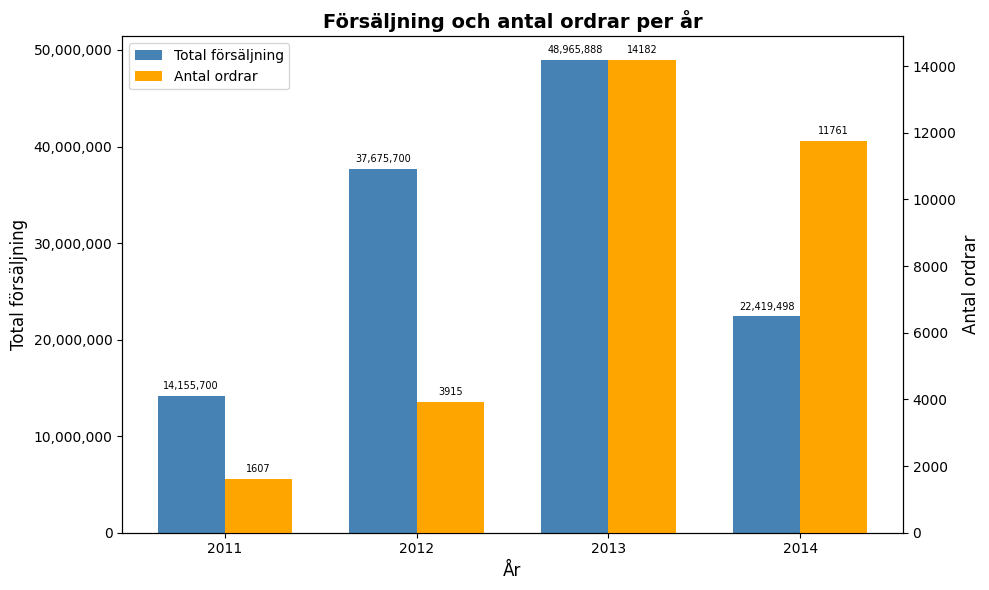

In [6]:
query_vis4 = """
SELECT
    YEAR(OrderDate) AS OrderYear,
    SUM(TotalDue) AS TotalSales,
    COUNT(SalesOrderID) AS OrderCount
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY OrderYear;
"""


df_vis4 = query_df(query_vis4)
display(df_vis4)

x = np.arange(len(df_vis4))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()  


bars1 = ax1.bar(x - width/2, df_vis4['TotalSales'], width, label='Total försäljning', color='steelblue')
bars2 = ax2.bar(x + width/2, df_vis4['OrderCount'], width, label='Antal ordrar', color='orange')


ax1.set_title('Försäljning och antal ordrar per år', fontsize=14, fontweight='bold')
ax1.set_xlabel('År', fontsize=12)
ax1.set_ylabel('Total försäljning', fontsize=12)
ax2.set_ylabel('Antal ordrar', fontsize=12)


ax1.set_xticks(x)
ax1.set_xticklabels(df_vis4['OrderYear'])


ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))


for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + max(df_vis4['TotalSales'])*0.01, f'{height:,.0f}', ha='center', va='bottom', fontsize=7)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + max(df_vis4['OrderCount'])*0.01, f'{height}', ha='center', va='bottom', fontsize=7)


handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()





### Insikter - Försäljning och antal ordrar per år

År 2011, 2012 och 2013 ökade både antal ordrar och total försäljning. Under 2014 är det en liten nedgång i både försäljning och antal ordrar. År 1013 är både ordrar och försäljning högst.



### Visualisering 5: Top 10 produkter efter försäljning  
 
Vilka 10 produkter genererar mest försäljning?

Hämtade TotalSales per produkt från SalesOrderDetail, summerade, sorterade och valde topp 10


Top 1 produkt: Mountain-200 Black, 38 (4,400,593)


,ProductName,TotalSales
0,"Mountain-200 Black, 38",4.400593e+06
1,"Mountain-200 Black, 42",4.009495e+06
2,"Mountain-200 Silver, 38",3.693678e+06
3,"Mountain-200 Silver, 42",3.438479e+06
4,"Mountain-200 Silver, 46",3.434257e+06
5,"Mountain-200 Black, 46",3.309673e+06
6,"Road-250 Black, 44",2.516857e+06
7,"Road-250 Black, 48",2.347656e+06
8,"Road-250 Black, 52",2.012448e+06
9,"Road-150 Red, 56",1.847819e+06


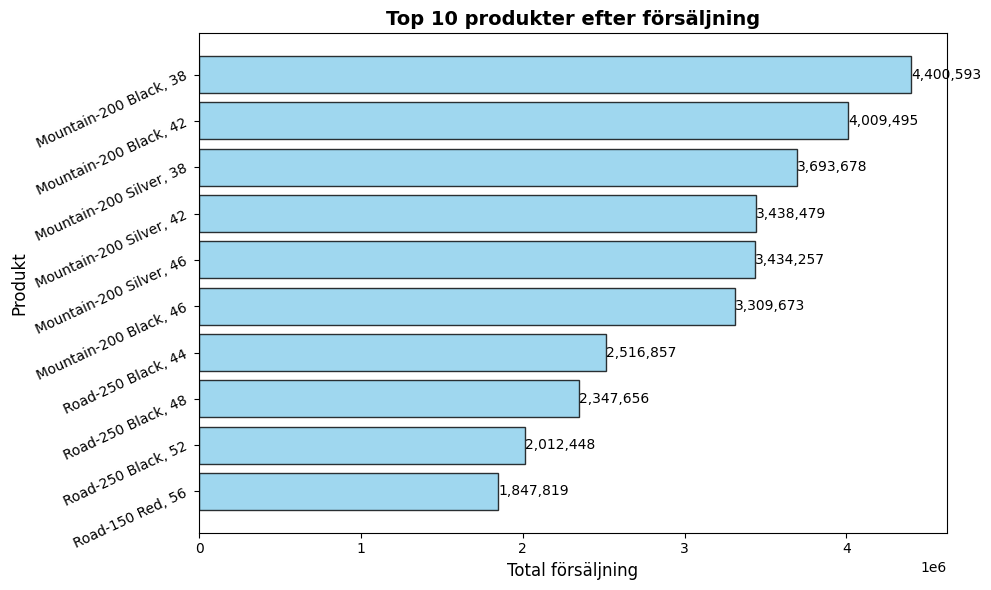

In [7]:
query_vis5 = """
SELECT TOP 10
    p.Name AS ProductName,
    SUM(sod.LineTotal) AS TotalSales
FROM Sales.SalesOrderDetail AS sod
INNER JOIN Production.Product AS p ON sod.ProductID = p.ProductID
GROUP BY p.Name
ORDER BY TotalSales DESC;
"""

df_vis5 = query_df(query_vis5)

top_product = df_vis5.iloc[0]['ProductName']
top_sales = df_vis5.iloc[0]['TotalSales']
print(f"Top 1 produkt: {top_product} ({top_sales:,.0f})")

display(df_vis5)

fig, ax = plt.subplots(figsize=(10,6))
bars = ax.barh(df_vis5['ProductName'], df_vis5['TotalSales'], color='skyblue', edgecolor='black', alpha=0.8)
ax.invert_yaxis()

for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:,.0f}', va='center')

ax.set_title('Top 10 produkter efter försäljning', fontsize=14, fontweight='bold')
ax.set_xlabel('Total försäljning', fontsize=12)
ax.set_ylabel('Produkt', fontsize=12)

plt.yticks(rotation=25)
plt.tight_layout()
plt.show()

### Insikter - Top 10 produkter

Mountain-200 Black, 38 är produkten med högst totala försäljningsvärde: 4,400,593.

